[toc]
 
# 推荐系统笔记 -- FM 模型 -- Numpy 实现

之前我们学习了关于 FM 模型的理论相关的内容。接下来我们进行实践，用 Numpy 来实现 FM 模型。

In [29]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

n_samples = 5
n_features = 10
n_factors = 3

初始化变量

In [30]:
np.random.seed(123)
x = np.random.normal(size=(n_samples, n_features))
y = np.random.normal(size=(n_samples,))
w0 =  0.0
w1 = np.random.normal(size=(n_features, 1))
v = np.random.normal(size=(n_features, n_factors))

In [31]:
def mse(y, yhat):
    return np.mean((y-yhat)**2)

## 前向传播过程

In [32]:
def forward(x, w0, w1, v):
    y = w0 + np.matmul(x, w1).squeeze() + 1/2 * np.sum(np.square(np.matmul(x, v)) - np.matmul(np.square(x), np.square(v)), axis=1)
    return y

## 反向传播

定义反向传播过程，这个过程相对于前向传播要复杂一些。

In [33]:
def backward(yhat, y, batch_x, w0, w1, v):

    dyhat = -2 * (y - yhat)

    n_samples = batch_x.shape[0]
    n_factors = v.shape[1]

    dw0 = np.sum(dyhat) / n_samples
    dw1 = batch_x.T @ dyhat / n_samples
    dw1 = dw1[:, np.newaxis]

    dv = np.zeros_like(v)
    for i in range(n_samples):
        x = batch_x[i][np.newaxis, :]
        dv += dyhat[i] * (x.T @ x @ v)
    dv -=  np.square(batch_x.T) @ dyhat[:, np.newaxis] @ np.ones(shape=[1, n_factors]) * v
    dv /= n_samples
    return dw0, dw1, dv

def apply_graidents(grads, variables, lr=0.001):
    for i in range(len(grads)):
        variables[i] -= lr * grads[i]

## 梯度检验

为了保证我们计算的梯度是正确的，这里我们使用 tensorflow 来进行求导，和我们的求导结果进行对比，验证结果是否正确。

In [34]:
def gradient_check(x, y, w0, w1, v):
    if x.ndim == 1:
        x = x[np.newaxis, :]
    x = tf.constant(x, dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    w0 = tf.Variable(w0, dtype=tf.float32)
    w1 = tf.Variable(w1, dtype=tf.float32)
    v = tf.Variable(v, dtype=tf.float32)
    with tf.GradientTape() as tape:
        yhat = w0 + tf.squeeze(tf.matmul(x, w1)) + 1 / 2 * tf.reduce_sum(tf.square(tf.matmul(x, v)) - tf.matmul(tf.square(x), tf.square(v)), axis=1)
        loss = tf.reduce_mean((y - yhat) ** 2)
    grads = tape.gradient(loss, [w0, w1, v])
    return grads

def check(x, y, w0, w1, v):
    yhat = forward(x, w0, w1, v)
    print(mse(y, yhat))
    grads = backward(yhat, y, x, w0, w1, v)
    grads_tf = gradient_check(x, y, w0, w1, v)
    print("Check whether gradients were computed correctly")
    print("Gradients computed: ", grads)
    print("Gradients compute by Tensorflow2: ", grads_tf)

# 检查梯度计算是否正确
check(x, y, w0, w1, v)

236.92758855609935
Check whether gradients were computed correctly
Gradients computed:  (-17.311901123456856, array([[  7.80684712],
       [-27.66410954],
       [-17.83897493],
       [  7.93775282],
       [ 19.55395587],
       [ -4.54315317],
       [ -5.87875768],
       [ -6.16395954],
       [-19.71319761],
       [ 11.45915318]]), array([[ 2.11818570e+01, -6.08334396e+00,  4.22278303e+01],
       [-3.82438873e+01,  3.21425002e+01, -3.70960365e+01],
       [-5.61884141e+01,  6.58812466e+01, -3.58850301e+01],
       [-3.99272474e+01,  2.70554706e+01,  4.33904374e+01],
       [ 8.02143941e+00, -1.08890581e+01, -4.23398091e+00],
       [ 1.20978497e-01, -4.14710441e+00, -2.95937881e+01],
       [ 1.20338390e+02, -3.19615767e+01, -6.65250996e-01],
       [-3.02180415e+01, -6.22813298e+01,  1.33312167e+02],
       [-2.19122481e+01,  4.27014043e+01, -7.50172741e+01],
       [ 1.44543466e+01,  1.61380697e+01,  1.26757992e+01]]))
Gradients compute by Tensorflow2:  [<tf.Tensor: shape=()

可以看到，结果是一致的，说明我们的求导结果是正确的。

## 模型训练与可视化

In [35]:
history = {"train_loss": []}
n_epochs = 100
for epoch in range(n_epochs):
    yhat = forward(x, w0, w1, v)
    loss_  = mse(y, yhat)
    grads = backward(yhat, y, x, w0, w1, v)
    apply_graidents(grads, [w0, w1, v])
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}/{n_epochs} Loss: {loss_}")
    history['train_loss'].append(loss_)

Epoch: 0/100 Loss: 236.92758855609935
Epoch: 10/100 Loss: 32.56128284916266
Epoch: 20/100 Loss: 10.021678878504991
Epoch: 30/100 Loss: 3.524252517255276
Epoch: 40/100 Loss: 1.3233504656952677
Epoch: 50/100 Loss: 0.5185948595239448
Epoch: 60/100 Loss: 0.20917091065261778
Epoch: 70/100 Loss: 0.08600919014581362
Epoch: 80/100 Loss: 0.03581744785404618
Epoch: 90/100 Loss: 0.015038720659917914


可视化

Text(0.5, 1.0, 'Loss')

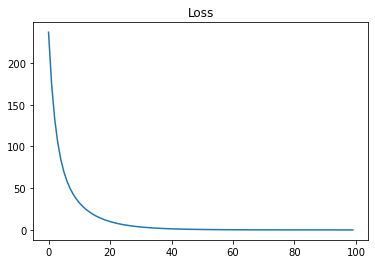

[-1.29408532 -1.03878821  1.74371223 -0.79806274  0.02968323]
[-1.30252685 -1.18633445  1.73018938 -0.77142474  0.12457443]


In [36]:
# 绘制loss曲线
plt.ion()
plt.plot(history['train_loss'])
plt.title("Loss")
plt.pause(0.05)
plt.close()

# 输出结果查看准确性
print(y)
print(forward(x, w0, w1, v))